In [60]:
#!{sys.executable} -m pip install geopandas
#!conda install --yes --prefix {sys.prefix} geopandas
%matplotlib inline
import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
from scipy import integrate
import seaborn as sns
import itertools
#from IAM_region_mapping import mappingDict
import json

In [61]:
## Parameters

# The gas we want to extract from the historical data

# gas = 'CO2'
gas = 'Kyoto Gases'

# Choose years for analysis

beginning_historical_data = 1850
beginning_pop_hist_data = 1960
end_historical_data = 2015
beginning_modelled_data = 2020
end_modelled_data = 2100
time_laps_model = 10
year_for_equity_calculation1 = 2050
year_for_equity_calculation2 = 2100

date_cumulative_beginning = 1990  # note that this should be after 1960 (the start of the population data)



# Group that are in the extracted historical data, but that are not countries

non_countries = ['ANNEXI', 'NONANNEXI', 'AOSIS', 'BASIC', 'EU28', 'LDC', 'UMBRELLA', 'EARTH']



#Variables of interest

var_image={'Emissions|CO2': 'Total_CO2',
       'Emissions|CO2|Carbon Capture and Storage|Biomass': 'BECCS',
       'Emissions|CO2|Land Use|Carbon Sequestration': 'LANDCDR',
          'Emissions|Kyoto Gases': 'Total_GHG',
          'Investment|Energy Supply|Electricity|Non-fossil|Biomass|w/ CCS':'BECCS_Investments',
          'Price|Carbon':'Carbon_Price'}
var_remind={'Emissions|CO2': 'Total_CO2',
            'Emissions|CO2|Carbon Capture and Storage|Biomass': 'BECCS',
            'Emissions|CO2|Land Use|Negative': 'LANDCDR',
           'Emissions|Kyoto Gases': 'Total_GHG',
           'Investment|Energy Supply|Electricity|Non-fossil|Biomass|w/ CCS':'BECCS_Investments',
           'Price|Carbon':'Carbon_Price'}
var_message={'Emissions|CO2': 'Total_CO2',
            'Carbon Sequestration|CCS|Biomass': 'BECCS',
            'Carbon Sequestration|Land Use': 'LANDCDR',
            'Emissions|Kyoto Gases': 'Total_GHG',
            'Investment|Energy Supply|Electricity|Biomass|w/ CCS':'BECCS_Investments',
            'Price|Carbon':'Carbon_Price'}

variable_names = ['Emissions|Kyoto Gases','Carbon Sequestration|Land Use','Carbon Sequestration|CCS|Biomass',
                  'Emissions|CO2|Carbon Capture and Storage|Biomass', 'Emissions|CO2|Land Use|Carbon Sequestration', 
                  'Emissions|CO2|Land Use|Negative', 'Investment|Energy Supply|Electricity|Biomass|w/ CCS', 'Price|Carbon']

# Paths
# data_path = "/Users/Broccolee/Google Drive/Grad School/TU BERLIN/Negative Emissions & Carbon Markets/Data/"
data_path = "/Users/kaylinlee/Desktop/KL_ISIpedia/Thesis/Code/Data/"
plot_path = "/Users/kaylinlee/Desktop/KL_ISIpedia/Thesis/Code/Plots/"


In [62]:
#Historical Population Data + Emission Data

pop_hist_file = "WDI2016_population_data.csv"
pop_data_hist = pd.read_csv(data_path+'WDI2016_population_data.csv', sep = ",",index_col=0)  #pop in million

primap_in = pd.read_csv(data_path + 'PRIMAP-hist_v2.0_11-Dec-2018.csv')

FAO_data = pd.read_excel(data_path + 'FAO_Emissions_Land_Use_Land_Use_Total_E_All_Data_NOFLAG.xlsx')

#print(pop_hist_file)
#print(primap_in)

In [5]:
# # MESSAGE model

# message_path = data_path + "MESSAGE_GLOBIOM/"

# model_name_message = 'MESSAGE'

# df_message = pd.read_csv(message_path + "ipccsr15_test_dbsnapshot.csv", sep = ";")

# scenario_names_message = ['SSP1-19', 'SSP2-19', 'SSP1-26', 'LowEnergyDemand', 'ADVANCE_2020_WB2C']


# # NAM without USA
# # CPA without CHN & HKG
# # SAS without IND
# regions_names_message = {
#  "R11_SAS": ["AFG", "BGD", "BTN", "LKA", "MDV", "NPL", "PAK"], 
#  "R11_EEU": ["ALB", "BGR", "BIH", "CZE", "EST", "HRV", "HUN", "LTU", "LVA", "MKD", "POL", "ROU", "SVN", "SVK", "SRB", "MNE"], 
#  "R11_MEA": ["ARE", "BHR", "DZA", "EGY", "IRN", "IRQ", "ISR", "JOR", "KWT", "LBN", "LBY", "MAR", "OMN", "QAT", "SAU", "SDN", "SYR", "TUN", "YEM"], 
#  "R11_PAS": ["ASM", "BRN", "FJI", "IDN", "KIR", "KOR", "MMR", "MYS", "NCL", "PHL", "PNG", "PYF", "SGP", "SLB", "THA", "TON", "TWN", "VUT", "WSM", "TLS"], 
#  "R11_WEU": ["AND", "AUT", "BEL", "CHE", "CYP", "DEU", "DNK", "ESP", "FIN", "FRA", "FRO", "GBR", "GIB", "GRC", "GRL", "IMN", "IRL", "ISL", "ITA", "LIE", "LUX", "MCO", "MLT", "NLD", "NOR", "PRT", "SWE", "TUR"], 
#  "R11_AFR": ["AGO", "BDI", "BEN", "BFA", "BWA", "CAF", "CIV", "CMR", "COG", "COM", "CPV", "DJI", "ERI", "ETH", "GAB", "GHA", "GIN", "GMB", "GNB", "GNQ", "IOT", "KEN", "LBR", "LSO", "MDG", "MLI", "MOZ", "MRT", "MUS", "MWI", "NAM", "NER", "NGA", "REU", "RWA", "SEN", "SHN", "SLE", "SOM", "STP", "SWZ", "SYC", "TCD", "TGO", "TZA", "UGA", "ZAF", "ZMB", "ZWE", "COG", "COD"], 
#  "R11_LAM": ["ARG", "ATG", "BHS", "BLZ", "BMU", "BOL", "BRA", "CHL", "COL", "CRI", "CUB", "DMA", "DOM", "ECU", "GLP", "GRD", "GTM", "GUY", "HND", "HTI", "JAM", "KNA", "MEX", "MTQ", "NIC", "PAN", "PER", "PRY", "SLV", "SUR", "TTO", "URY", "VCT", "VEN"], 
#  "R11_FSU": ["ARM", "AZE", "BLR", "GEO", "KAZ", "KGZ", "MDA", "RUS", "TJK", "TKM", "UKR", "UZB"], 
#  "R11_PAO": ["AUS", "JPN", "NZL"], 
#  "R11_CPA": ["KHM", "LAO", "MNG", "PRK", "VNM"], 
#  "R11_NAM": ["CAN", "GUM", "PRI", "VGB"],
#  "USA": ['USA'],
#  "CHN": ['CHN', "HKG"],
#  "IND": ['IND'],
#  "EU" : ["ALB", "BGR", "BIH", "CZE", "EST", "HRV", "HUN", "LTU", "LVA", "MKD", "POL", "ROU", "SVN", "SVK", "SRB", "MNE", "AND", "AUT", "BEL", "CHE", "CYP", "DEU", "DNK", "ESP", "FIN", "FRA", "FRO", "GBR", "GIB", "GRC", "GRL", "IMN", "IRL", "ISL", "ITA", "LIE", "LUX", "MCO", "MLT", "NLD", "NOR", "PRT", "SWE", "TUR"],
#  "World": ['EARTH', 'WLD']
# }



In [6]:
# ## Getting MESSAGE data format to match the other models
# df_message = df_message.rename(columns={"MODEL": "Model", "SCENARIO": "Scenario", "REGION": "Region", "VARIABLE":"Variable", "UNIT": "Unit", "YEAR": 'Year', "VALUE": 'Value'})

# df_message_copy = df_message.copy()
# # df_message_copy = df_message_copy.loc[df_message_copy.Variable.isin(variable_names)]
# df_pivot = pd.pivot_table(df_message_copy, values='Value', index = ['Scenario', 'Region', 'Variable', 'Model', 'Unit'], columns=['Year'], aggfunc = np.sum)
# df_pivot_res = df_pivot.reset_index()
# df_message = pd.DataFrame(df_pivot_res)
# df_message = df_message.drop(columns = [2000])
# df_message.to_csv(data_path + 'message_help', index=False) 
# df_message = pd.read_csv(data_path + 'message_help')
# df_message= df_message[df_message.Region != 'R5ASIA']
# df_message= df_message[df_message.Region != 'R5LAM']
# df_message= df_message[df_message.Region != 'R5MAF']
# df_message= df_message[df_message.Region != 'R5OECD90+EU']
# df_message= df_message[df_message.Region != 'R5REF']
# df_message= df_message[df_message.Region != 'R11_NAM']
# df_message= df_message[df_message.Region != 'R11_CPA']
# df_message= df_message[df_message.Region != 'R11_SAS']
# df_message= df_message[df_message.Region != 'R11_WEU']
# df_message= df_message[df_message.Region != 'R11_EEU']

# df_message.rename(columns={'2005': 2005,
#                           '2010': 2010,
#                           '2020': 2020,
#                           '2030': 2030,
#                           '2040': 2040,
#                           '2050': 2050,
#                           '2060': 2060,
#                           '2070': 2070,
#                           '2080': 2080,
#                           '2090': 2090,
#                           '2100': 2100}, 
#                  inplace=True)
# df_message = df_message[['Model', 'Scenario', 'Region', 'Variable', 'Unit', 2005, 2010, 2020, 2030, 2040, 2050, 2060, 2070, 2080, 2090, 2100]]
# df_message

,Model,Scenario,Region,Variable,Unit,2005,2010,2020,2030,2040,2050,2060,2070,2080,2090,2100
0,MESSAGE-GLOBIOM 1.0,ADVANCE_2020_1.5C-2100,CHN,Capacity|Electricity|Biomass,GW,0.407790,0.440720,0.275850,5.123790,5.491130,6.616400,9.110480,22.915600,25.096390,25.502870,23.026080
1,MESSAGE-GLOBIOM 1.0,ADVANCE_2020_1.5C-2100,CHN,Capacity|Electricity|Coal,GW,403.117530,755.858960,972.012160,778.129030,308.549880,22.006320,2.797860,1.093390,0.000000,0.000000,0.000000
2,MESSAGE-GLOBIOM 1.0,ADVANCE_2020_1.5C-2100,CHN,Capacity|Electricity|Gas,GW,6.332510,17.208040,33.967230,57.190280,61.426300,89.409250,62.354100,45.425830,129.277200,223.886650,307.358150
3,MESSAGE-GLOBIOM 1.0,ADVANCE_2020_1.5C-2100,CHN,Capacity|Electricity|Geothermal,GW,0.000000,0.045000,0.045000,0.780510,1.589660,2.576000,3.778340,5.243990,7.030610,8.357140,8.357140
4,MESSAGE-GLOBIOM 1.0,ADVANCE_2020_1.5C-2100,CHN,Capacity|Electricity|Hydro,GW,109.416660,270.029450,270.047740,477.742840,486.071410,491.039630,499.839540,486.607160,486.607160,486.607160,486.607160
5,MESSAGE-GLOBIOM 1.0,ADVANCE_2020_1.5C-2100,CHN,Capacity|Electricity|Nuclear,GW,6.587000,9.437000,82.949900,189.328700,426.559600,771.277600,1131.502900,1057.990000,950.527700,710.003300,360.225300
6,MESSAGE-GLOBIOM 1.0,ADVANCE_2020_1.5C-2100,CHN,Capacity|Electricity|Oil,GW,10.424220,8.406560,7.436220,1.600280,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,MESSAGE-GLOBIOM 1.0,ADVANCE_2020_1.5C-2100,CHN,Capacity|Electricity|Solar,GW,0.000000,1.200000,9.875790,684.346690,1148.581090,1605.198800,1754.673700,2609.558300,2590.050400,2558.274200,2600.949590
8,MESSAGE-GLOBIOM 1.0,ADVANCE_2020_1.5C-2100,CHN,Capacity|Electricity|Solar|CSP,GW,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.603390
9,MESSAGE-GLOBIOM 1.0,ADVANCE_2020_1.5C-2100,CHN,Capacity|Electricity|Solar|PV,GW,0.000000,1.200000,9.875790,684.346690,1148.581090,1605.198800,1754.673700,2609.558300,2590.050400,2558.274200,2594.346200


In [7]:
# print(df_message.loc[(df_message.Region == 'World') & (df_message.Variable == 'Price|Carbon') & (df_message.Scenario == 'SSP1-19')])
# print(df_message.loc[(df_message.Region == 'World') & (df_message.Variable == 'Price|Carbon') & (df_message.Scenario == 'LowEnergyDemand')])

Empty DataFrame
Columns: [Model, Scenario, Region, Variable, Unit, 2005, 2010, 2020, 2030, 2040, 2050, 2060, 2070, 2080, 2090, 2100]
Index: []
                       Model         Scenario Region      Variable  \
52597  MESSAGEix-GLOBIOM 1.0  LowEnergyDemand  World  Price|Carbon   

                Unit  2005  2010      2020       2030        2040        2050  \
52597  US$2010/t CO2   0.0   0.0  0.234714  88.917016  119.497034  160.594016   

             2060        2070        2080        2090        2100  
52597  215.824936  290.050665  389.803852  523.863798  704.029113  


In [8]:
# # MESSAGE DATA CLEAN-UP for carbon price
# df_carbon_price = df_message.loc[(df_message.Variable == 'Price|Carbon')]
# #df_carbon_price = df_message.filter(Variable='Price|Carbon', Year=range(2030, 2101, 10))
# print(df_carbon_price)

# # 2030 carbon price values below 5 
# scen_w_invalid_CarbonPrice = df_message.loc[(df_message.Variable == 'Price|Carbon') & 
#                                             (df_message[2030] < 5)].Scenario.unique()
# print(scen_w_invalid_CarbonPrice)
# #print(df_message.Scenario.unique()-scen_w_invalid_CarbonPrice)

# # carbon price values are NaN in any time series
# #print(df_message.isnull().any(axis=1))
# #print(df_carbon_price.apply(lambda x: np.isnan(max(x)), axis=1))
# #null_data = df_message.loc[df_message.isnull() ]
# #print(null_data)

                       Model                Scenario   Region      Variable  \
118      MESSAGE-GLOBIOM 1.0  ADVANCE_2020_1.5C-2100      CHN  Price|Carbon   
307      MESSAGE-GLOBIOM 1.0  ADVANCE_2020_1.5C-2100       EU  Price|Carbon   
496      MESSAGE-GLOBIOM 1.0  ADVANCE_2020_1.5C-2100      IND  Price|Carbon   
685      MESSAGE-GLOBIOM 1.0  ADVANCE_2020_1.5C-2100  R11_AFR  Price|Carbon   
1252     MESSAGE-GLOBIOM 1.0  ADVANCE_2020_1.5C-2100  R11_FSU  Price|Carbon   
1441     MESSAGE-GLOBIOM 1.0  ADVANCE_2020_1.5C-2100  R11_LAM  Price|Carbon   
1630     MESSAGE-GLOBIOM 1.0  ADVANCE_2020_1.5C-2100  R11_MEA  Price|Carbon   
2008     MESSAGE-GLOBIOM 1.0  ADVANCE_2020_1.5C-2100  R11_PAO  Price|Carbon   
2197     MESSAGE-GLOBIOM 1.0  ADVANCE_2020_1.5C-2100  R11_PAS  Price|Carbon   
3709     MESSAGE-GLOBIOM 1.0  ADVANCE_2020_1.5C-2100      USA  Price|Carbon   
3956     MESSAGE-GLOBIOM 1.0  ADVANCE_2020_1.5C-2100    World  Price|Carbon   
4145     MESSAGE-GLOBIOM 1.0      ADVANCE_2020_Med2C

In [63]:
#REMIND Model

remind_path = data_path + "REMIND/SSPs/"
model_name_remind = 'REMIND'


remind_SSP1_19 = pd.read_csv(remind_path + "SSP1-19-SPA1-V17_corr.mif", sep = ";")
remind_SSP1_26 = pd.read_csv(remind_path + "SSP1-26-SPA1-V17_corr.mif", sep = ";")
remind_SSP2_19 = pd.read_csv(remind_path + "SSP2-19-SPA2-V17_corr.mif", sep = ";")
remind_SSP2_26 = pd.read_csv(remind_path + "SSP2-26-SPA2-V17_corr.mif", sep = ";")
remind_SSP5_19 = pd.read_csv(remind_path + "SSP5-19-SPA5-V17_corr.mif", sep = ";")
remind_SSP5_26 = pd.read_csv(remind_path + "SSP5-26-SPA5-V17_corr.mif", sep = ";")


regions_names_remind = {
    "ROW": ['ALB', 'AND', 'ATA', 'AUS', 'BIH', 'BLR', 'BVT', 'CAN', 'CHE', 'GGY', 'HMD', 'HRV', 'ISL', 'LIE', 'MAF'
            'MCO', 'MDA', 'MKD', 'MNE', 'NOR', 'NRU', 'NZL', 'SGS', 'SJM', 'SMR', 'SPM', 'SRB', 'TUR', 'UKR', 'VAT',
            'ZAF'], 
    "USA": ['USA', 'PRI'],
    "LAM": ['ABW', 'AIA', 'ARG', 'ATG', 'BES', 'BHS', 'BLM', 'BLZ', 'BMU', 'BOL', 'BRA', 'BRB', 'CHL', 'COL', 'CRI',
            'CUB', 'CUW', 'CYM', 'DMA', 'DOM', 'ECU', 'FLK', 'GLP', 'GRD', 'GTM', 'GUF', 'GUY', 'HND', 'HTI', 'JAM',
            'KNA', 'LCA', 'MEX', 'MSR', 'MTQ', 'NIC', 'PAN', 'PER', 'PRY', 'SLV', 'SUR', 'SXM', 'TCA', 'TTO', 'URY',
            'VCT', 'VEN', 'VGB', 'VIR'],
    "EUR": ['ALA', 'AUT', 'BEL', 'BGR', 'CYP', 'CZE', 'DEU', 'DNK', 'ESP', 'EST', 'FIN', 'FRA', 'FRO', 'GBR', 'GIB',
            'GRC', 'GRL', 'HUN', 'IMN', 'IRL', 'ITA', 'JEY', 'LTU', 'LUX', 'LVA', 'MLT', 'NLD', 'POL', 'PRT', 'ROU',
            'SVK', 'SVN', 'SWE'],
    "AFR": ['AGO', 'BDI', 'BEN', 'BFA', 'BWA', 'CAF', 'CIV', 'CMR', 'COD', 'COG', 'COM', 'CPV', 'DJI', 'ERI', 'ETH', 
            'GAB', 'GHA', 'GIN', 'GMB', 'GNB', 'GNQ', 'KEN', 'LBR', 'LSO', 'MDG', 'MLI', 'MOZ', 'MRT', 'MUS', 'MWI',
            'MYT', 'NAM', 'NER', 'NGA', 'REU', 'RWA', 'SDN', 'SEN', 'SHN', 'SLE', 'SOM', 'SSD', 'STP', 'SWZ', 'SYC',
            'TCD', 'TGO', 'TZA', 'UGA', 'ZMB', 'ZWE'],
    "MEA": ['ARE', 'ARM', 'AZE', 'BHR', 'DZA', 'EGY', 'ESH', 'GEO', 'IRN', 'IRQ', 'ISR', 'JOR', 'KAZ', 'KGZ', 'KWT',
            'LBN', 'LBY', 'MAR', 'OMN', 'PSE', 'QAT', 'SAU', 'SYR', 'TJK', 'TKM', 'TUN', 'UZB', 'YEM'],
    "IND": ['IND'],
    "RUS": ['RUS'],
    "CHN": ['CHN', 'HKG', 'MAC'],
    "JPN": ['JPN'],
    "OAS": ['AFG', 'ASM', 'ATF', 'BGD', 'BRN', 'BTN', 'CCK', 'COK', 'CXR', 'FJI', 'FSM', 'GUM', 'IDN', 'IOT', 'KHM',
            'KIR', 'KOR', 'LAO', 'LKA', 'MDV', 'MHL', 'MMR', 'MNG', 'MNP', 'MYS', 'NCL', 'NFK', 'NIU', 'NPL', 'PAK',
            'PCN', 'PHL', 'PLW', 'PNG', 'PRK', 'PYF', 'SGP', 'SLB', 'THA', 'TKL', 'TLS', 'TON', 'TUV', 'TWN', 'UMI',
            'VNM', 'VUT', 'WLF', 'WSM'],
    "World": ['ALB', 'AND', 'ATA', 'AUS', 'BIH', 'BLR', 'BVT', 'CAN', 'CHE', 'GGY', 'HMD', 'HRV', 'ISL', 'LIE', 'MAF'
            'MCO', 'MDA', 'MKD', 'MNE', 'NOR', 'NRU', 'NZL', 'SGS', 'SJM', 'SMR', 'SPM', 'SRB', 'TUR', 'UKR', 'VAT',
            'ZAF', 'USA', 'PRI', 'ABW', 'AIA', 'ARG', 'ATG', 'BES', 'BHS', 'BLM', 'BLZ', 'BMU', 'BOL', 'BRA', 'BRB',
            'CHL', 'COL', 'CRI', 'CUB', 'CUW', 'CYM', 'DMA', 'DOM', 'ECU', 'FLK', 'GLP', 'GRD', 'GTM', 'GUF', 'GUY', 
            'HND', 'HTI', 'JAM', 'KNA', 'LCA', 'MEX', 'MSR', 'MTQ', 'NIC', 'PAN', 'PER', 'PRY', 'SLV', 'SUR', 'SXM', 
            'TCA', 'TTO', 'URY', 'VCT', 'VEN', 'VGB', 'VIR', 'ALA', 'AUT', 'BEL', 'BGR', 'CYP', 'CZE', 'DEU', 'DNK', 
            'ESP', 'EST', 'FIN', 'FRA', 'FRO', 'GBR', 'GIB', 'GRC', 'GRL', 'HUN', 'IMN', 'IRL', 'ITA', 'JEY', 'LTU', 
            'LUX', 'LVA', 'MLT', 'NLD', 'POL', 'PRT', 'ROU', 'SVK', 'SVN', 'SWE', 'AGO', 'BDI', 'BEN', 'BFA', 'BWA', 
            'CAF', 'CIV', 'CMR', 'COD', 'COG', 'COM', 'CPV', 'DJI', 'ERI', 'ETH', 'GAB', 'GHA', 'GIN', 'GMB', 'GNB', 
            'GNQ', 'KEN', 'LBR', 'LSO', 'MDG', 'MLI', 'MOZ', 'MRT', 'MUS', 'MWI', 'MYT', 'NAM', 'NER', 'NGA', 'REU',
            'RWA', 'SDN', 'SEN', 'SHN', 'SLE', 'SOM', 'SSD', 'STP', 'SWZ', 'SYC', 'TCD', 'TGO', 'TZA', 'UGA', 'ZMB', 
            'ZWE', 'ARE', 'ARM', 'AZE', 'BHR', 'DZA', 'EGY', 'ESH', 'GEO', 'IRN', 'IRQ', 'ISR', 'JOR', 'KAZ', 'KGZ', 
            'KWT', 'LBN', 'LBY', 'MAR', 'OMN', 'PSE', 'QAT', 'SAU', 'SYR', 'TJK', 'TKM', 'TUN', 'UZB', 'YEM', 'IND',
            'RUS', 'CHN', 'HKG', 'MAC', 'JPN', 'AFG', 'ASM', 'ATF', 'BGD', 'BRN', 'BTN', 'CCK', 'COK', 'CXR', 'FJI', 
            'FSM', 'GUM', 'IDN', 'IOT', 'KHM', 'KIR', 'KOR', 'LAO', 'LKA', 'MDV', 'MHL', 'MMR', 'MNG', 'MNP', 'MYS',
            'NCL', 'NFK', 'NIU', 'NPL', 'PAK', 'PCN', 'PHL', 'PLW', 'PNG', 'PRK', 'PYF', 'SGP', 'SLB', 'THA', 'TKL', 
            'TLS', 'TON', 'TUV', 'TWN', 'UMI', 'VNM', 'VUT', 'WLF', 'WSM']
}


In [64]:
df_remind = remind_SSP1_19.append(remind_SSP2_19, ignore_index = True)
df_remind = df_remind.append(remind_SSP1_26, ignore_index = True)
df_remind = df_remind.append(remind_SSP2_26, ignore_index = True)
df_remind = df_remind.append(remind_SSP5_19, ignore_index = True)
df_remind = df_remind.append(remind_SSP5_26, ignore_index = True)

df_remind['2005'] = df_remind['2005'].apply(pd.to_numeric)
df_remind['2010'] = df_remind['2010'].apply(pd.to_numeric)
df_remind['2020'] = df_remind['2020'].apply(pd.to_numeric)
df_remind['2030'] = df_remind['2030'].apply(pd.to_numeric)
df_remind['2040'] = df_remind['2040'].apply(pd.to_numeric)
df_remind['2050'] = df_remind['2050'].apply(pd.to_numeric)
df_remind['2060'] = df_remind['2060'].apply(pd.to_numeric)
df_remind['2070'] = df_remind['2070'].apply(pd.to_numeric)
df_remind['2080'] = df_remind['2080'].apply(pd.to_numeric)
df_remind['2090'] = df_remind['2090'].apply(pd.to_numeric)
df_remind['2100'] = df_remind['2100'].apply(pd.to_numeric)

df_remind.rename(columns={'2005': 2005,
                          '2010': 2010,
                          '2020': 2020,
                          '2030': 2030,
                          '2040': 2040,
                          '2050': 2050,
                          '2060': 2060,
                          '2070': 2070,
                          '2080': 2080,
                          '2090': 2090,
                          '2100': 2100}, 
                 inplace=True)

print(df_remind)

               Model          Scenario Region  \
0      REMIND-MAGPIE  SSP1-19-SPA1-V17    AFR   
1      REMIND-MAGPIE  SSP1-19-SPA1-V17    CHN   
2      REMIND-MAGPIE  SSP1-19-SPA1-V17    EUR   
3      REMIND-MAGPIE  SSP1-19-SPA1-V17    IND   
4      REMIND-MAGPIE  SSP1-19-SPA1-V17    JPN   
...              ...               ...    ...   
55175  REMIND-MAGPIE  SSP5-26-SPA5-V17    OAS   
55176  REMIND-MAGPIE  SSP5-26-SPA5-V17    ROW   
55177  REMIND-MAGPIE  SSP5-26-SPA5-V17    RUS   
55178  REMIND-MAGPIE  SSP5-26-SPA5-V17    USA   
55179  REMIND-MAGPIE  SSP5-26-SPA5-V17  World   

                              Variable       Unit      2005      2010  \
0                 Capacity|Electricity         GW   27.7200   36.4500   
1                 Capacity|Electricity         GW  434.1000  775.4000   
2                 Capacity|Electricity         GW  638.5000  678.6000   
3                 Capacity|Electricity         GW  134.7000  176.5000   
4                 Capacity|Electricity        

In [11]:
print(df_remind.loc[(df_remind.Region == 'USA') & (df_remind.Variable == 'Price|Carbon') 
                    & (df_remind.Scenario == 'SSP1-19-SPA1-V17')])

              Model          Scenario Region      Variable           Unit  \
4908  REMIND-MAGPIE  SSP1-19-SPA1-V17    USA  Price|Carbon  US$2005/t CO2   

      2005  2010  2020   2030   2040   2050   2060   2070   2080   2090   2100  
4908   0.0   0.0  12.0  1.145  1.865  3.038  4.949  8.062  13.13  21.39  34.84  


In [69]:
#IMAGE model

model_name_image = 'IMAGE'


data_file_image = data_path + 'IMAGE_SSP1-1.9_SSP2-1.9/IMAGE_SSP1-1.9_SSP2-1.9_and_baselines.xlsx'

scenario_names_image = ['SSP1-19-SPA0-V17', 'SSP1-Ref-SPA0-V17', 'SSP2-LF-SPA2-V17', 'SSP2-Ref-SPA0-V17']  

variable_names_image = ['Emissions|CO2', 'Emissions|Kyoto Gases','Emissions|CO2|Carbon Capture and Storage|Biomass',
                  'Emissions|CO2|Land Use|Carbon Sequestration', 'Emissions|CO2|Land Use|Negative',
                        'Investment|Energy Supply|Electricity|Non-fossil|Biomass|w/ CCS','Price|Carbon']

df_image = pd.read_excel(data_file_image, sheet_name=0)


# Create a regional dictionary
regions_names_image = {
    "World": ['EARTH', 'WLD'],
    "BRA": ['BRA'],
    "CAN": ['CAN'],
    "CEU": ['ALB', 'BIH', 'BGR', 'HRV', 'CYP', 'CZE', 'EST', 'HUN', 'LVA', 'LTU', 'MKD', 'POL', 'ROU', 'SRB', 'MNE',
            'SVK', 'SVN'],
    "CHN": ['CHN', 'TWN', 'HKG', 'MAC', 'MNG'],
    "EAF": ['BDI', 'COM', 'ETH', 'ERI', 'DJI', 'KEN', 'MDG', 'MUS', 'RWA', 'SYC', 'SOM', 'SDN', 'SSD', 'UGA'],
    "INDIA": ['IND'],
    "INDO": ['IDN', 'PNG', 'TLS'],
    "JAP": ['JPN'],
    "KOR": ['KOR', 'PRK'],
    "ME": ['BHR', 'IRN', 'IRQ', 'ISR', 'JOR', 'KWT', 'LBN', 'OMN', 'QAT', 'SAU', 'SYR', 'ARE', 'YEM'],
    "MEX": ['MEX'],
    "NAF": ['DZA', 'LBY', 'MAR', 'TUN', 'EGY'],
    "OCE": ['WSM', 'AUS', 'SLB', 'COK', 'FJI', 'KIR', 'NRU', 'VUT', 'NZL', 'NIU', 'FSM', 'MHL', 'PLW', 'PCN', 'TUV'],
    "RCAM": ['BHS', 'BRB', 'ATG', 'BLZ', 'VGB', 'CRI', 'DOM', 'SLV', 'GRD', 'GTM', 'HTI', 'HND', 'JAM', 'ABW', 'NIC',
             'PAN', 'AIA', 'KNA', 'LCA', 'VCT', 'TTO', 'TCA', 'TKL', 'TON', ''],
    "RSAF": ['AGO', 'BWA', 'LSO', 'MWI', 'MOZ', 'NAM', 'ZWE', 'SWZ', 'TZA', 'ZMB'],
    "RSAM": ['ARG', 'BOL', 'CHL', 'COL', 'ECU', 'GUY', 'PRY', 'PER', 'SUR', 'URY', 'VEN'],
    "RSAS": ['AFG', 'BGD', 'BTN', 'MDV', 'NPL', 'PAK', 'LKA'],
    "RUS": ['RUS', 'AZE', 'ARM', 'GEO'],
    "SAF": ['ZAF'],
    "SEAS": ['BRN', 'MMR', 'KHM', 'LAO', 'MYS', 'PHL', 'SGP', 'THA', 'VNM'],
    "STAN": ['KAZ', 'KGZ', 'TKM', 'TJK', 'UZB'],
    "TUR": ['TUR'],
    "UKR": ['UKR', 'BLR', 'MDA'],
    "USA": ['USA'],
    "WAF": ['CAM', 'CPV', 'CAF', 'TCD', 'COD', 'COG', 'BEN', 'GNQ', 'GAB', 'GNB', 'GHA', 'GIN', 'CIV', 'LBR', 'MLI',
            'MRT', 'NER', 'NGA', 'GNB', 'SHN', 'STP', 'SEN', 'SLE', 'TGO', 'BFA'],
    "WEU": ['AND', 'AUT', 'BEL', 'DNK', 'FIN', 'FRA', 'DEU', 'GRC', 'VAT', 'ISL', 'IRL', 'ITA', 'LIE', 'LUX', 'MCO',
            'NLD', 'NOR', 'PRT', 'SMR', 'ESP', 'SWE', 'CHE', 'GBR', 'MLT']
}

In [71]:
image_scens_to_delete = df_image.loc[(df_image.Variable == 'Price|Carbon') & (df_image[2030] < 5)].Scenario.unique()
df_image[~df_image.Scenario.isin(image_scens_to_delete)].Scenario.unique()

array(['SSP1-19-SPA0-V17', 'SSP2-LF-SPA2-V17'], dtype=object)

In [68]:
remind_scens_to_delete = df_remind.loc[(df_remind.Variable == 'Price|Carbon') & (df_remind[2030] < 5)].Scenario.unique()
#print(remind_scens_to_delete) #'SSP1-19-SPA1-V17' 'SSP2-19-SPA2-V17'
df_remind[~df_remind.Scenario.isin(remind_scens_to_delete)].Scenario.unique()

array(['SSP1-26-SPA1-V17', 'SSP2-26-SPA2-V17', 'SSP5-19-SPA5-V17',
       'SSP5-26-SPA5-V17'], dtype=object)

In [72]:
#exclude scenarios that have mireported prices: Carbon prices below 5 USD/tCO2 in 2030 or reported as NaN
def delete_invalid_carbon_price(main_df):
    scens_to_delete = main_df.loc[(main_df.Variable == 'Price|Carbon') & (main_df[2030] < 5)].Scenario.unique()
    return main_df[~main_df.Scenario.isin(scens_to_delete)]

df_image = delete_invalid_carbon_price(df_image)
#df_message = delete_invalid_cabon_price(df_message)
df_remind = delete_invalid_carbon_price(df_remind)

In [73]:
#check if any price|carbon values are missing
df_image.loc[(df_image.Variable == 'Price|Carbon')].isnull().values.any()
df_remind.loc[(df_remind.Variable == 'Price|Carbon')].isnull().values.any()

False

In [59]:
df_remind.loc[(df_remind.Variable == 'Price|Carbon')][2050].min()

80.33

In [57]:
df_image.loc[(df_image.Variable == 'Price|Carbon')][2050].max()

940.90909185

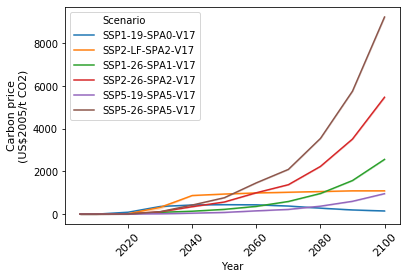

In [51]:
cp_data=pd.concat([df_image.loc[df_image.Variable == 'Price|Carbon'],
                   df_remind.loc[df_remind.Variable == 'Price|Carbon']]).drop(columns=['Model','Region',
                                                                                       'Variable','Unit'])
cp_data=pd.melt(cp_data,id_vars=['Scenario'],var_name='Year', value_name='Carbon_price').copy()

sns.lineplot(x='Year', y='Carbon_price', hue='Scenario', data=cp_data)
plt.ylabel('Carbon price\n(US$2005/t CO2)', fontsize = 11)
plt.xticks(fontsize = 11, rotation = 45)
plt.savefig(plot_path + 'cp_projections_for_all_scens.png', bbox_inches='tight')

# CALCULATING HISTORICAL EMISSIONS FOR EQUITY SCHEMES



In [75]:
#Set up mdf_model dataframe (historic emission data for model regions)

def masterdf_calc(regions_names):
    mdf = pd.DataFrame(columns=['Year','Country','Value','Variable','Unit','Model','Scenario'])
    
    # PRIMAP Filter
    scen='HISTCR'
    cat='IPCM0EL'
    gas='KYOTOGHGAR4' #'CO2'
    
    for region in regions_names:                                      
        # Filter for countries in region, transpose (to get years on rows) and sum over countries
        cfiltdata=primap_in.loc[(primap_in.category==cat)&
                      (primap_in.scenario==scen)&
                      (primap_in.country.isin(regions_names[region]))&
                      (primap_in.entity==gas)].iloc[:,5:].transpose()

        tempdf=pd.DataFrame(columns=['Year','Country','Value','Variable','Unit','Model','Scenario'])
        tempdf['Year']=cfiltdata.index
        tempdf['Value']=cfiltdata.sum(axis=1).values*10**(-3) # Convert from Gg in Mt
        tempdf['Country']=region
        tempdf['Variable']='Kyoto Gases' #'CO2'
        tempdf['Unit']='Mt/yr'
        tempdf['Model']='PRIMAP'
        tempdf['Scenario']='HIST'

        mdf=mdf.append(tempdf,ignore_index=True)
    return mdf
        
mdf_remind = masterdf_calc(regions_names_remind)
mdf_image = masterdf_calc(regions_names_image)
#mdf_message = masterdf_calc(regions_names_message)

In [76]:
#add historic landuse emissions (FAO_data)

def hist_landem_calc(regions_names):
    mdf = pd.DataFrame(columns=['Year','Country','Value_2','Variable','Unit','Model','Scenario'])
    # FAO Filter
    
    item='Land Use total'
    element='Net emissions/removals (CO2eq)'
    
    for region in regions_names:                                      
        # Filter for countries in region, transpose (to get years on rows) and sum over countries
        cfiltdata=FAO_data.loc[(FAO_data.Item==item)&
                      (FAO_data.Country_code.isin(regions_names[region]))&
                      (FAO_data.Element==element)].iloc[:,8:].transpose()
        
        tempdf=pd.DataFrame(columns=['Year','Country','Value_2','Variable','Unit','Model','Scenario'])
        tempdf['Year']=cfiltdata.index
        tempdf['Value_2']=cfiltdata.sum(axis=1).values*10**(-3) # Convert from Gg in Mt
        tempdf['Country']=region
        tempdf['Variable']='Kyoto Gases' #'CO2'
        tempdf['Unit']='Mt/yr'
        tempdf['Model']='PRIMAP'
        mdf=mdf.append(tempdf,ignore_index=True)
    return mdf
        
m_remind = hist_landem_calc(regions_names_remind)
m_image = hist_landem_calc(regions_names_image)
#m_message = hist_landem_calc(regions_names_message)

In [77]:
def add_FAO_data_calc(mdf, m_df): 
    years_todel = list(range(1850, 1990))
    ranger = [str(x) for x in years_todel]

    for ye in mdf.Year:
        if ye in ranger:
            mdf = mdf[mdf.Year != ye]

    mdf = mdf.reset_index()
    
    df_merge = pd.merge(mdf, m_df, on = mdf.index, how = 'left')
    df_merge = df_merge.drop(columns=['Country_y', 'Variable_y', 'Unit_y', 'Model_y', 'Scenario_y', 'key_0', 'index', 'Year_y'])

    df_merge['Value_sum']= df_merge['Value']+df_merge['Value_2']

    df_merge.columns = ['Year', 'Country', 'Value', 'Variable', 'Unit', 'Model', 'Scenario', 'Value_2', 'Value_sum']
    df_merge = df_merge.drop(columns = ['Value_2', 'Value'])

    df_merge.rename(columns = {'Value_sum':'Value'}, inplace = True)

    return(df_merge)

mdf_remind = add_FAO_data_calc(mdf_remind, m_remind)
mdf_image = add_FAO_data_calc(mdf_image, m_image)
#mdf_message = add_FAO_data_calc(mdf_message, m_message)
#print(mdf_image)

In [78]:
#%% DERIVE CUMULATIVE EMISSIONS FROM 1990 UP TO 2015

def cum_em_calc(mdf):


    #cum_em_df = pd.DataFrame(index=mdf.Country.unique(), columns=['Cum_Em_CO2_Gg'])
    #for region in cum_em_df.index:
     #   cum_em_df.loc[region, :] = mdf.loc[(mdf.Country == region) &
      #                                     (mdf.Year >= str(date_cumulative_beginning)) &
       #                                    (mdf.Year < str(end_historical_data)), 'Value'].sum(axis=0) 

    cum_em_df = pd.DataFrame(index=mdf.Country.unique(), columns=['Cum_Em_CO2_Gg'])
    for region in cum_em_df.index:
        cum_em_df.loc[region, :] = mdf.loc[(mdf.Country == region) &
                                           (mdf.Year >= str(date_cumulative_beginning)) &
                                           (mdf.Year < str(end_historical_data+1)), 'Value'].sum(axis=0)     
    return cum_em_df


cum_em_df_remind = cum_em_calc(mdf_remind)
cum_em_df_image = cum_em_calc(mdf_image)
#cum_em_df_message = cum_em_calc(mdf_message)


# ADDING CUMULATIVE EMISSIONS TO THE DATASETS 

In [83]:
# DERIVE RELEVANT QUANTITIES ON REGIONAL LEVEL - copied from 2.
#Set up main dataframe with CUM_CO2 and CUM_CDR and CUM_BECCS

var_image={'Emissions|CO2': 'Total_CO2',
       'Emissions|CO2|Carbon Capture and Storage|Biomass': 'BECCS',
       'Emissions|CO2|Land Use|Carbon Sequestration': 'LANDCDR',
          'Emissions|Kyoto Gases': 'Total_GHG',
          'Investment|Energy Supply|Electricity|Non-fossil|Biomass|w/ CCS':'BECCS_Investments',
          'Price|Carbon':'Carbon_Price'}
var_remind={'Emissions|CO2': 'Total_CO2',
            'Emissions|CO2|Carbon Capture and Storage|Biomass': 'BECCS',
            'Emissions|CO2|Land Use|Negative': 'LANDCDR',
           'Emissions|Kyoto Gases': 'Total_GHG',
           'Investment|Energy Supply|Electricity|Non-fossil|Biomass|w/ CCS':'BECCS_Investments',
           'Price|Carbon':'Carbon_Price'}
variable_names = ['Emissions|CO2','Emissions|Kyoto Gases','Carbon Sequestration|Land Use','Carbon Sequestration|CCS|Biomass',
                  'Emissions|CO2|Carbon Capture and Storage|Biomass', 'Emissions|CO2|Land Use|Carbon Sequestration', 
                  'Emissions|CO2|Land Use|Negative','Investment|Energy Supply|Electricity|Non-fossil|Biomass|w/ CCS',
                  'Price|Carbon']



years=df_image.keys()[7:]                # start in 2020

def main_df(model, hist_data, master_dataframe, variables, model_name):
    
    red_dat_ref=model.loc[model.Variable.isin(variable_names)]
    
    full_df=pd.DataFrame(columns=['MODEL','Region','Scenario','Year','Total_CO2','Total_GHG','BECCS','LANDCDR',
                                  'TOTAL_CDR','CO2_Emissions','CUM_CO2','CUM_CDR', 'CUM_BECCS','Unit_CO2',
                                  'BECCS_Investments','CUM_BECCS_Investments', 'Unit_Investment','Carbon_Price'])
    full_df["Unit_CO2"]= 'Mt/yr'
    full_df["Unit_Investment"]= 'billion US$2005/yr' ##for REMIND & IMAGE
#    full_df["Unit_Investment"]= 'billion US$2010/yr'##for MESSAGE
    full_df["MODEL"] = model_name

    for scen,reg in itertools.product(red_dat_ref.Scenario.unique(),red_dat_ref.Region.unique()): ## for IMAGE / REMIND
#    for scen,reg in itertools.product(['SSP1-19','LowEnergyDemand'], red_dat_ref.Region.unique()): ## for MESSAGE, because SSP2 scenarios don't have all values. Had to delete 'SSP1-26' because no GDP data
#     for scen in scenario_names_message:
#         for reg in red_dat_ref.Region.unique():
        tempdf=pd.DataFrame(columns=['MODEL','Region','Scenario','Year','Total_CO2','Total_GHG','BECCS','LANDCDR',
                                     'TOTAL_CDR','CO2_Emissions','CUM_CO2','CUM_CDR', 'CUM_BECCS', 'Unit_CO2',
                                     'BECCS_Investments','CUM_BECCS_Investments', 'Unit_Investment','Carbon_Price'])
        tempdf["Unit_CO2"]= 'Mt/yr'
        tempdf["Unit_Investment"]= 'billion US$2005/yr' ##REMIND & IMAGE
#        tempdf["Unit_Investment"]= 'billion US$2010/yr' ##MESSAGE
        tempdf["Year"]=years
        tempdf["Region"]=reg
        tempdf["Scenario"]=scen
        tempdf["MODEL"] = model_name
        
        for var in red_dat_ref.Variable.unique():
            tempdf[variables[var]]=red_dat_ref.loc[(red_dat_ref.Scenario==scen)&
                            (red_dat_ref.Region==reg)&
                            (red_dat_ref.Variable==var),red_dat_ref.keys()[7:]].iloc[0,:].values

#        tempdf['LANDCDR'] = tempdf['LANDCDR']*(-1)                             # only Remind
        #tempdf['TOTAL_CDR']=tempdf['BECCS']+tempdf['LANDCDR']+tempdf['DAC']   # only Strefler  
        #tempdf['TOTAL_CDR']=tempdf['TOTAL_CDR']*(-1)                          # only Strefler
#         num = tempdf['LANDCDR']._get_numeric_data() # because some LANDCDR values are negative (use this method when neg LANDCDR is related to BECCS)
        tempdf['TOTAL_CDR']=tempdf['BECCS']+tempdf['LANDCDR']
        num = tempdf['TOTAL_CDR']._get_numeric_data() # because some LANDCDR values are negative 
        num[num < 0] = 0
        #         tempdf['CO2_Emissions']=tempdf['Total_CO2']+tempdf['TOTAL_CDR']   #CO2_Emissions is CO2_em without CDR
        tempdf['CO2_Emissions']=tempdf['Total_GHG']+tempdf['TOTAL_CDR']       #Total_CO2 is CO2 with -CDR
                                                                            #Choose Total_CO2 or Total_GHG



    # ADD HISTORIC EMISSIONS UP TO 2015 AND FILL IN BETWEEN 2015 AND 2020 
        for reg in tempdf.Region.unique():    
        # Fill in years between 2015 and 2020 
            add15_to_20=5*0.5*(master_dataframe.loc[(master_dataframe.Country==reg)&(master_dataframe.Year==str(end_historical_data)),'Value'].values[0]
                               +tempdf.loc[(tempdf.Region==reg)&(tempdf.Year==beginning_modelled_data),'CO2_Emissions'])

        #Add cumulative historic emissions up to 2015
            add15_to_20+=hist_data.loc[reg,'Cum_Em_CO2_Gg']

# Add cumulative emissions to model 2020 levels
            tempdf.loc[(tempdf.Region==reg)&(tempdf.Year==beginning_modelled_data),'CUM_CO2']=add15_to_20    

    # DERIVE CUMULATIVE CDR FROM 2020
        tempdf['CUM_CDR']=tempdf.loc[tempdf['Year']==beginning_modelled_data,'TOTAL_CDR']
        tempdf['CUM_BECCS']=tempdf.loc[tempdf['Year']==beginning_modelled_data,'BECCS']
        tempdf['CUM_BECCS_Investments']=tempdf.loc[tempdf['Year']==beginning_modelled_data,'BECCS_Investments']
    
        for year in years[1:]:
        # 10 year steps but emissions in CO2/yr, interpolate linearly
            cumco2=tempdf.loc[tempdf['Year']==year-10,'CUM_CO2'].values+10*0.5*(tempdf.loc[tempdf['Year']==year,'CO2_Emissions'].values+tempdf.loc[tempdf['Year']==year-10,'CO2_Emissions'].values)
            cumcdr=tempdf.loc[tempdf['Year']==year-10,'CUM_CDR'].values+10*0.5*(tempdf.loc[tempdf['Year']==year,'TOTAL_CDR'].values+tempdf.loc[tempdf['Year']==year-10,'TOTAL_CDR'].values)
            cumbeccs=tempdf.loc[tempdf['Year']==year-10,'CUM_BECCS'].values+10*0.5*(tempdf.loc[tempdf['Year']==year,'BECCS'].values+tempdf.loc[tempdf['Year']==year-10,'BECCS'].values)
            cuminv=tempdf.loc[tempdf['Year']==year-10,'CUM_BECCS_Investments'].values+10*0.5*(tempdf.loc[tempdf['Year']==year,'BECCS_Investments'].values+tempdf.loc[tempdf['Year']==year-10,'BECCS_Investments'].values)

            tempdf.loc[tempdf['Year']==year,'CUM_CO2']=cumco2 
            tempdf.loc[tempdf['Year']==year,'CUM_CDR']=cumcdr
            tempdf.loc[tempdf['Year']==year,'CUM_BECCS']=cumbeccs
            tempdf.loc[tempdf['Year']==year,'CUM_BECCS_Investments']=cuminv
            
        full_df=full_df.append(tempdf,ignore_index=True)

# Correct for 'object' datatypes in output
        full_df['CUM_CO2']=full_df['CUM_CO2'].astype('float64', copy=True)
        full_df['Unit_CO2'] = 'Mt/yr'
#        full_df['Unit_Investment'] = 'billion US$2010/yr'
        full_df['Unit_Investment'] = 'billion US$2005/yr' ##IMAGE & REMIND
        
        
    return full_df
    
    
    
main_image = main_df(df_image, cum_em_df_image, mdf_image, var_image, model_name_image)

In [86]:
main_image.head(10)

,MODEL,Region,Scenario,Year,Total_CO2,Total_GHG,BECCS,LANDCDR,TOTAL_CDR,CO2_Emissions,CUM_CO2,CUM_CDR,CUM_BECCS,Unit_CO2,BECCS_Investments,CUM_BECCS_Investments,Unit_Investment,Carbon_Price
0,IMAGE,BRA,SSP1-19-SPA0-V17,2020,1027.143687,1669.133057,6.396825,-175.239091,0.000000,1669.133057,49348.871739,0.000000,6.396825,Mt/yr,0.148890,0.148890,billion US$2005/yr,90.455400
1,IMAGE,BRA,SSP1-19-SPA0-V17,2030,454.394587,1031.937012,28.671569,-121.852387,0.000000,1031.937012,62854.222081,0.000000,181.738796,Mt/yr,0.722734,4.507007,billion US$2005/yr,359.173629
2,IMAGE,BRA,SSP1-19-SPA0-V17,2040,700.045868,1324.442993,53.872183,-183.313216,0.000000,1324.442993,74636.122105,0.000000,594.457557,Mt/yr,0.281383,9.527592,billion US$2005/yr,429.445912
3,IMAGE,BRA,SSP1-19-SPA0-V17,2050,142.483662,703.756897,71.836045,14.957297,86.793342,790.550239,85211.088265,433.966709,1222.998696,Mt/yr,0.296773,12.418374,billion US$2005/yr,444.229348
4,IMAGE,BRA,SSP1-19-SPA0-V17,2060,20.306294,568.658020,78.908312,95.778358,174.686670,743.344690,92880.562909,1741.366768,1976.720479,Mt/yr,0.335006,15.577269,billion US$2005/yr,436.761808
5,IMAGE,BRA,SSP1-19-SPA0-V17,2070,-206.553789,349.490692,110.593882,323.409354,434.003236,783.493928,100514.756000,4784.816299,2924.231449,Mt/yr,0.504008,19.772341,billion US$2005/yr,379.722823
6,IMAGE,BRA,SSP1-19-SPA0-V17,2080,-527.841609,27.446051,179.113968,519.859741,698.973709,726.419760,108064.324440,10449.701024,4372.770700,Mt/yr,0.429754,24.441152,billion US$2005/yr,280.648083
7,IMAGE,BRA,SSP1-19-SPA0-V17,2090,-522.033610,35.775421,237.558412,459.323804,696.882215,732.657636,115359.711420,17428.980646,6456.132598,Mt/yr,0.025592,26.717883,billion US$2005/yr,196.661433
8,IMAGE,BRA,SSP1-19-SPA0-V17,2100,-748.534256,-189.222900,287.653085,618.433332,906.086416,716.863516,122607.317180,25443.823802,9082.190078,Mt/yr,0.000000,26.845846,billion US$2005/yr,148.878879
9,IMAGE,CAN,SSP1-19-SPA0-V17,2020,405.788175,529.120117,0.853885,60.322373,61.176257,590.296375,25491.834925,61.176257,0.853885,Mt/yr,0.023301,0.023301,billion US$2005/yr,90.455400


In [87]:
#REMIND datafram

years=df_image.keys()[7:]                # start in 2020

def main_df(model, hist_data, master_dataframe, variables, model_name):
    
    red_dat_ref=model.loc[model.Variable.isin(variable_names)]
    
    full_df=pd.DataFrame(columns=['MODEL','Region','Scenario','Year','Total_CO2','Total_GHG','BECCS','LANDCDR',
                                  'TOTAL_CDR','CO2_Emissions','CUM_CO2','CUM_CDR', 'CUM_BECCS','Unit_CO2',
                                  'BECCS_Investments','CUM_BECCS_Investments', 'Unit_Investment','Carbon_Price'])
    full_df["Unit_CO2"]= 'Mt/yr'
    full_df["Unit_Investment"]= 'billion US$2005/yr' ##for REMIND & IMAGE
    full_df["MODEL"] = model_name

    for scen,reg in itertools.product(red_dat_ref.Scenario.unique(),red_dat_ref.Region.unique()): ## for IMAGE / REMIND
        tempdf=pd.DataFrame(columns=['MODEL','Region','Scenario','Year','Total_CO2','Total_GHG','BECCS','LANDCDR',
                                     'TOTAL_CDR','CO2_Emissions','CUM_CO2','CUM_CDR', 'CUM_BECCS', 'Unit_CO2',
                                     'BECCS_Investments','CUM_BECCS_Investments', 'Unit_Investment','Carbon_Price'])
        tempdf["Unit_CO2"]= 'Mt/yr'
        tempdf["Unit_Investment"]= 'billion US$2005/yr' ##REMIND & IMAGE
        tempdf["Year"]=years
        tempdf["Region"]=reg
        tempdf["Scenario"]=scen
        tempdf["MODEL"] = model_name
        
        for var in red_dat_ref.Variable.unique():
            tempdf[variables[var]]=red_dat_ref.loc[(red_dat_ref.Scenario==scen)&
                            (red_dat_ref.Region==reg)&
                            (red_dat_ref.Variable==var),red_dat_ref.keys()[7:]].iloc[0,:].values

        tempdf['LANDCDR'] = tempdf['LANDCDR']*(-1)                             # only Remind
        tempdf['TOTAL_CDR']=tempdf['BECCS']+tempdf['LANDCDR']
        num = tempdf['TOTAL_CDR']._get_numeric_data() # because some LANDCDR values are negative 
        num[num < 0] = 0
        #         tempdf['CO2_Emissions']=tempdf['Total_CO2']+tempdf['TOTAL_CDR']   #CO2_Emissions is CO2_em without CDR
        tempdf['CO2_Emissions']=tempdf['Total_GHG']+tempdf['TOTAL_CDR']       #Total_CO2 is CO2 with -CDR
                                                                            #Choose Total_CO2 or Total_GHG



    # ADD HISTORIC EMISSIONS UP TO 2015 AND FILL IN BETWEEN 2015 AND 2020 
        for reg in tempdf.Region.unique():    
        # Fill in years between 2015 and 2020 
            add15_to_20=5*0.5*(master_dataframe.loc[(master_dataframe.Country==reg)&(master_dataframe.Year==str(end_historical_data)),'Value'].values[0]
                               +tempdf.loc[(tempdf.Region==reg)&(tempdf.Year==beginning_modelled_data),'CO2_Emissions'])

        #Add cumulative historic emissions up to 2015
            add15_to_20+=hist_data.loc[reg,'Cum_Em_CO2_Gg']

# Add cumulative emissions to model 2020 levels
            tempdf.loc[(tempdf.Region==reg)&(tempdf.Year==beginning_modelled_data),'CUM_CO2']=add15_to_20    

    # DERIVE CUMULATIVE CDR FROM 2020
        tempdf['CUM_CDR']=tempdf.loc[tempdf['Year']==beginning_modelled_data,'TOTAL_CDR']
        tempdf['CUM_BECCS']=tempdf.loc[tempdf['Year']==beginning_modelled_data,'BECCS']
        tempdf['CUM_BECCS_Investments']=tempdf.loc[tempdf['Year']==beginning_modelled_data,'BECCS_Investments']
    
        for year in years[1:]:
        # 10 year steps but emissions in CO2/yr, interpolate linearly
            cumco2=tempdf.loc[tempdf['Year']==year-10,'CUM_CO2'].values+10*0.5*(tempdf.loc[tempdf['Year']==year,'CO2_Emissions'].values+tempdf.loc[tempdf['Year']==year-10,'CO2_Emissions'].values)
            cumcdr=tempdf.loc[tempdf['Year']==year-10,'CUM_CDR'].values+10*0.5*(tempdf.loc[tempdf['Year']==year,'TOTAL_CDR'].values+tempdf.loc[tempdf['Year']==year-10,'TOTAL_CDR'].values)
            cumbeccs=tempdf.loc[tempdf['Year']==year-10,'CUM_BECCS'].values+10*0.5*(tempdf.loc[tempdf['Year']==year,'BECCS'].values+tempdf.loc[tempdf['Year']==year-10,'BECCS'].values)
            cuminv=tempdf.loc[tempdf['Year']==year-10,'CUM_BECCS_Investments'].values+10*0.5*(tempdf.loc[tempdf['Year']==year,'BECCS_Investments'].values+tempdf.loc[tempdf['Year']==year-10,'BECCS_Investments'].values)

            tempdf.loc[tempdf['Year']==year,'CUM_CO2']=cumco2 
            tempdf.loc[tempdf['Year']==year,'CUM_CDR']=cumcdr
            tempdf.loc[tempdf['Year']==year,'CUM_BECCS']=cumbeccs
            tempdf.loc[tempdf['Year']==year,'CUM_BECCS_Investments']=cuminv
            
        full_df=full_df.append(tempdf,ignore_index=True)

# Correct for 'object' datatypes in output
        full_df['CUM_CO2']=full_df['CUM_CO2'].astype('float64', copy=True)
        full_df['Unit_CO2'] = 'Mt/yr'
        full_df['Unit_Investment'] = 'billion US$2005/yr' ##IMAGE & REMIND
        
        
    return full_df
    
    
main_remind = main_df(df_remind, cum_em_df_remind, mdf_remind, var_remind, model_name_remind)

In [89]:
main_remind.Scenario.unique()

array(['SSP1-26-SPA1-V17', 'SSP2-26-SPA2-V17', 'SSP5-19-SPA5-V17',
       'SSP5-26-SPA5-V17'], dtype=object)

In [97]:
#add columns Carbon_Price X TOTAL_CDR, Carbon_Price X BECCS
#price unit = $2005/ton
#CO2 unit = Mt/yr 

def withPriceXCDR(main_df):
    main_df[['Carbon_Price','TOTAL_CDR','BECCS']] = main_df[['Carbon_Price','TOTAL_CDR','BECCS']].astype(float)
    main_df['PriceXTotalCDR'] = main_df['Carbon_Price'] * main_df['TOTAL_CDR'] * 0.001
    main_df['Unit_PriceXTotalCDR'] = 'billion_US$2005/yr' 
    main_df['PriceXBECCS'] = main_df['Carbon_Price'] * main_df['BECCS'] * 0.001
    main_df['Unit_PriceXBECCS'] = 'billion_US$2005/yr'
    return main_df

#main_message = withPriceXTotalCDR(main_message)
main_remind = withPriceXCDR(main_remind)
main_image = withPriceXCDR(main_image)

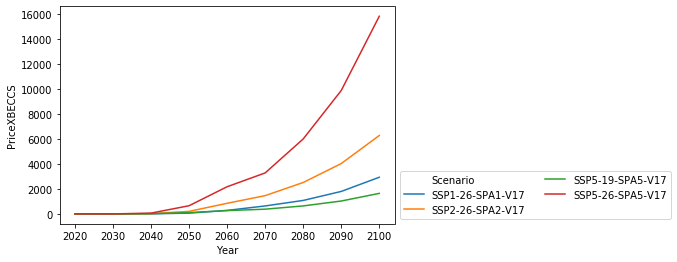

In [98]:
single_reg=main_remind[main_remind.Region=='AFR'].copy()
sns.lineplot(x='Year',y='PriceXBECCS',data=single_reg,hue=main_remind.Scenario)
plt.legend(loc='lower left', bbox_to_anchor=(1,0),ncol=2)
#plt.yscale('log')


# DERIVE CUMULATIVE POPULATION and GDP

## Population
- Derive historic population from World Bank Data up to 2015 (annual data)
- Derive future populations from IAM (10 year interpolation)
- Fill in between 2015 to 2020

## GDP
- take GDP|MER [TO CHECK!], infill annual values

In [108]:
cum_em_df_remind.index

Index(['ROW', 'USA', 'LAM', 'EUR', 'AFR', 'MEA', 'IND', 'RUS', 'CHN', 'JPN',
       'OAS', 'World'],
      dtype='object')

In [111]:
main_remind

,MODEL,Region,Scenario,Year,Total_CO2,Total_GHG,BECCS,LANDCDR,TOTAL_CDR,CO2_Emissions,...,CUM_BECCS,Unit_CO2,BECCS_Investments,CUM_BECCS_Investments,Unit_Investment,Carbon_Price,PriceXTotalCDR,PriceXBECCS,Unit_PriceXTotalCDR,Unit_PriceXBECCS
0,REMIND,AFR,SSP1-26-SPA1-V17,2020,1228.0057,3233.0,0.006,119.6861,119.6921,3352.6921,...,0.0060,Mt/yr,0.0013,0.0013,billion US$2005/yr,1.00,0.119692,0.000006,billion_US$2005/yr,billion_US$2005/yr
1,REMIND,AFR,SSP1-26-SPA1-V17,2030,1370.0148,3367.0,4.024,24.8400,28.8640,3395.8640,...,20.1560,Mt/yr,0.0000,0.0078,billion US$2005/yr,84.22,2.430926,0.338901,billion_US$2005/yr,billion_US$2005/yr
2,REMIND,AFR,SSP1-26-SPA1-V17,2040,1893.3051,4358.0,50.300,7.4355,57.7355,4415.7355,...,291.7760,Mt/yr,0.0000,0.0078,billion US$2005/yr,137.20,7.921311,6.901160,billion_US$2005/yr,billion_US$2005/yr
3,REMIND,AFR,SSP1-26-SPA1-V17,2050,1848.3224,4731.0,282.500,20.0497,302.5497,5033.5497,...,1955.7760,Mt/yr,0.0001,0.0083,billion US$2005/yr,223.50,67.619858,63.138750,billion_US$2005/yr,billion_US$2005/yr
4,REMIND,AFR,SSP1-26-SPA1-V17,2060,1462.5287,4455.0,774.600,4.8513,779.4513,5234.4513,...,7241.2760,Mt/yr,0.0003,0.0103,billion US$2005/yr,364.00,283.720273,281.954400,billion_US$2005/yr,billion_US$2005/yr
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
427,REMIND,World,SSP5-26-SPA5-V17,2060,7483.2768,17170.0,14030.000,133.7322,14163.7322,31333.7322,...,162686.0068,Mt/yr,7.5330,117.2126,billion US$2005/yr,1466.00,20764.031405,20567.980000,billion_US$2005/yr,billion_US$2005/yr
428,REMIND,World,SSP5-26-SPA5-V17,2070,-3988.3296,5360.0,17190.000,90.2859,17280.2859,22640.2859,...,318786.0068,Mt/yr,18.7500,248.6276,billion US$2005/yr,2095.00,36202.198960,36013.050000,billion_US$2005/yr,billion_US$2005/yr
429,REMIND,World,SSP5-26-SPA5-V17,2080,-11349.6725,-2804.0,19390.000,90.6408,19480.6408,16676.6408,...,501686.0068,Mt/yr,54.9300,617.0276,billion US$2005/yr,3545.00,69058.871636,68737.550000,billion_US$2005/yr,billion_US$2005/yr
430,REMIND,World,SSP5-26-SPA5-V17,2090,-16493.7559,-8552.0,20980.000,62.3360,21042.3360,12490.3360,...,703536.0068,Mt/yr,109.1000,1437.1776,billion US$2005/yr,5761.00,121224.897696,120865.780000,billion_US$2005/yr,billion_US$2005/yr


In [110]:
# CUMMULATIVE HISTORIC POPULATION

#reg='WEU'         # ??

#historic population model region specific

def cum_historic_pop_calc(model, hist_data, regions_names):
    cum_hist_pop=pd.DataFrame(index=regions_names,columns=['Cum_Hist_Pop'])

    for reg in hist_data.index:
        pop_reg_time=pop_data_hist.loc[regions_names[reg],np.arange(date_cumulative_beginning, 
                                                                    end_historical_data+1).astype('str')]  # +1 to make the function go from 1990 to 2015
        cum_hist_pop.loc[reg,'Cum_Hist_Pop']=pop_reg_time.sum().sum()
    return cum_hist_pop

    # CHECK BETWEEN SUM OF COUNTRIES AND TOTAL WORLD POPULATION - MISMATCH DUE TO MISSING COUNTRIES IN REGIONAL CLASSIFICATION
    #print('Cum Pop sum over region', cum_hist_pop[cum_hist_pop.index!='World'].sum())
    #print('Cum Pop World', cum_hist_pop.loc['World'])
    #print(cum_hist_pop) #in millions 1990-2015

cum_hist_pop_remind = cum_historic_pop_calc(main_remind, cum_em_df_remind, regions_names_remind)
cum_hist_pop_image = cum_historic_pop_calc(main_image, cum_em_df_image, regions_names_image)

KeyError: 'Passing list-likes to .loc or [] with any missing labels is no longer supported, see https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike'

In [69]:
# DERIVE CUMULATIVE POPULATION GOING FORWARD      -   Alternative way to do it (to use: remove hashtags, works only with data in 10 year steps)
  
def gdp_pop_calc(main_df, model):   
    #full_df['CUM_POP']=np.nan
    main_df['Population']=np.nan
    main_df['GDP']=np.nan
    main_df['Unit_Population'] = 'Mio'

    for reg,scen in itertools.product(main_df.Region.unique(),main_df.Scenario.unique()):  ## for IMAGE / REMIND
  #  for reg,scen in itertools.product(main_df.Region.unique(),['SSP1-19','LowEnergyDemand']):  ## MESSAGE
        # Get population from scenario and run
        pop_iam=model.loc[(model.Scenario==scen)&
            (model.Region==reg)&(model.Variable=='Population'),:].iloc[0,7:]

        main_df.loc[(main_df.Year==beginning_modelled_data)&
                (main_df.Scenario==scen)&
                (main_df.Region==reg),'Population']=pop_iam.loc[beginning_modelled_data]
        try:
            main_df.loc[(main_df.Year==beginning_modelled_data)&
            (main_df.Scenario==scen)&
            (main_df.Region==reg),'GDP']=model.loc[(model.Scenario==scen)&
                                (model.Region==reg)&(model.Variable=='GDP|PPP'),beginning_modelled_data].iloc[0]
        except:
            print(reg, scen)                        

        # DERIVE CUMULATIVE POPULATION
        # Fill in years between 2015 and 2020 
    #    add15_to_20=5*0.5*(pop_data_hist.loc[regions_names[reg],str(end_historical_data)].sum()
    #                       +pop_iam.loc[2020])

        # Add historic population
    #    add15_to_20+=cum_hist_pop.loc[reg]

    #    full_df.loc[(full_df.Year==beginning_modelled_data)&
    #            (full_df.Scenario==scen)&
    #            (full_df.Region==reg),'CUM_POP']=add15_to_20[0]

        # DERIVE CUMULATIVE POPULATION GOING FORWARD
        for year in years[1:]:
            main_df.loc[(main_df.Year==year)&
                (main_df.Scenario==scen)&
                (main_df.Region==reg),'Population']=pop_iam.loc[year]
            # 10 year steps but emissions in CO2/yr, interpolate linearly
    #        full_df.loc[(full_df.Year==year)&
    #            (full_df.Scenario==scen)&
    #            (full_df.Region==reg),'CUM_POP']=10*0.5*(pop_iam.loc[year-10]
     #                                                    +pop_iam.loc[year])+full_df.loc[
      #                                                                      (full_df.Year==year-10)&
       #                                                                     (full_df.Scenario==scen)&
        #                                                                   (full_df.Region==reg),'CUM_POP'].values
            # GDP
            main_df.loc[(main_df.Year==year)&
            (main_df.Scenario==scen)&
            
                        (main_df.Region==reg),'GDP']=model.loc[(model.Scenario==scen)&
                                                        (model.Region==reg)&
                                                       (model.Variable=='GDP|PPP'),year].iloc[0]

    return main_df

main_image = gdp_pop_calc(main_image, df_image)
main_remind = gdp_pop_calc(main_remind, df_remind)
#main_message = gdp_pop_calc(main_message, df_message)
#main_strefler = gdp_pop_calc(main_strefler, df_remind_strefler)

In [70]:
# cum_pop Calculation (works also with data that is not necessarily in 10year steps)

def cum_pop_calc(main_df, cum_hist_pop_data, regions_names):

    main_df['cumPopulation'] = 0

    for reg in main_df.Region.unique():
        mask = main_df.Region == reg
        full_reg = main_df.loc[mask,:]

        for scen in full_reg.Scenario.unique():
            mask_scen = full_reg.Scenario == scen
            full_scen = full_reg.loc[mask_scen,:]
            integral = integrate.cumtrapz(y = full_scen.Population, x = full_scen.Year, initial = 0)
            pop_in_2020 = full_scen.loc[(full_scen.Year == beginning_modelled_data), 'Population']
            pop_in_2020 = int(pop_in_2020)
            diff15_20 = 5*0.5*(pop_data_hist.loc[regions_names[reg], '2015'].sum() 
                               + full_scen.loc[(full_scen.Year == beginning_modelled_data), 'Population'])
            diff15_20+=cum_hist_pop_data.loc[reg].values

            integral += diff15_20.values
            full_reg.loc[mask_scen,'cumPopulation'] += integral

        main_df.loc[mask,'cumPopulation'] = full_reg.loc[:,'cumPopulation']

    return main_df
    
main_remind = cum_pop_calc(main_remind, cum_hist_pop_remind, regions_names_remind)
main_image = cum_pop_calc(main_image, cum_hist_pop_image, regions_names_image)
#main_message = cum_pop_calc(main_message, cum_hist_pop_message, regions_names_message)
#main_strefler = cum_pop_calc(main_strefler, cum_hist_pop_strefler, regions_names_remind)


In [71]:
def historic_2016(mdf, main_df): #mdf is the dataframe with historic emissions data, main_df is the model df

    main_df.loc[:,'2016_emissions'] = 0
    val2016 = mdf.loc[mdf.Year == '2016']

    for reg in main_df.Region.unique():
        rfilt = (main_df.Region == reg)
        val_reg = val2016.loc[(val2016.Country == reg), 'Value'].values
        for scen in main_df.Scenario.unique():
            sfilt = (main_df.Scenario == scen)
            for yr in main_df.Year.unique():
                yfilt = (main_df.Year == yr)
                main_df.loc[rfilt & sfilt & yfilt,'2016_emissions'] = val_reg
                
    return main_df

main_image = historic_2016(mdf_image, main_image)
main_remind = historic_2016(mdf_remind, main_remind)
#SLmain_message = historic_2016(mdf_message, main_message)

In [72]:
def change_from_historic(mdf, main_df): #mdf is the dataframe with historic emissions data, main_df is the model df

    main_df.loc[:,'em_change'] = 0

    for reg in main_df.Region.unique():
        rfilt = (main_df.Region == reg)
        for scen in main_df.Scenario.unique():
            sfilt = (main_df.Scenario == scen)
            for yr in main_df.Year.unique():
                yfilt = (main_df.Year == yr)
                main_df.loc[rfilt & sfilt & yfilt,'em_change'] = main_df.loc[rfilt & sfilt & yfilt, 'CO2_Emissions'] / main_df.loc[rfilt & sfilt & yfilt,'2016_emissions']
                
    return main_df

main_image = change_from_historic(mdf_image, main_image)
main_remind = change_from_historic(mdf_remind, main_remind)
#main_message = change_from_historic(mdf_message, main_message)

In [ ]:
# EXCEL EXPORT

#def excel_export_calc(main_df, model_name):
#    main_df.to_excel(data_path + model_name + '/' + 'processed_output_inkl2015.xls'

main_image.to_excel(data_path + 'IMAGE_processed_output_FAO_wCP.xls')
main_remind.to_excel(data_path + 'REMIND_processed_output_FAO_wCP.xls')

# BACKUP: Add CPXBECCS & CPXTotal CDR 

In [112]:
#IMPORT EXCEL
main_remind=pd.read_excel(data_path+'REMIND_processed_output_FAO.xls')
main_image=pd.read_excel(data_path+'IMAGE_processed_output_FAO.xls')

In [123]:
# exclude'SSP1-19-SPA1-V17', 'SSP2-19-SPA2-V17'
main_remind.loc[(main_remind.Year == 2030) & (main_remind.Carbon_Price<5)].Scenario.unique()

array(['SSP1-19-SPA1-V17', 'SSP2-19-SPA2-V17'], dtype=object)

In [125]:
#exclude scenarios that have mireported prices: Carbon prices below 5 USD/tCO2 in 2030 or reported as NaN
def delete_invalid_carbon_price(main_df):
    scens_to_delete = main_df.loc[(main_df.Year == 2030) & (main_df.Carbon_Price <5)].Scenario.unique()
    return main_df[~main_df.Scenario.isin(scens_to_delete)]

main_image = delete_invalid_carbon_price(main_image)
main_remind = delete_invalid_carbon_price(main_remind)

In [129]:
#add columns Carbon_Price X TOTAL_CDR, Carbon_Price X BECCS
#price unit = $2005/ton
#CO2 unit = Mt/yr 

def withPriceXCDR(main_df):
    main_df[['Carbon_Price','TOTAL_CDR','BECCS']] = main_df[['Carbon_Price','TOTAL_CDR','BECCS']].astype(float)
    main_df['PriceXTotalCDR'] = main_df['Carbon_Price'] * main_df['TOTAL_CDR'] * 0.001
    main_df['Unit_PriceXTotalCDR'] = 'billion_US$2005/yr' 
    main_df['PriceXBECCS'] = main_df['Carbon_Price'] * main_df['BECCS'] * 0.001
    main_df['Unit_PriceXBECCS'] = 'billion_US$2005/yr'
    return main_df

#main_message = withPriceXTotalCDR(main_message)
main_remind = withPriceXCDR(main_remind)
main_image = withPriceXCDR(main_image)

In [140]:
# EXCEL EXPORT
main_image.to_excel(data_path + 'IMAGE_processed_output_FAO_wCP.xls')
main_remind.to_excel(data_path + 'REMIND_processed_output_FAO_wCP.xls')

In [136]:
main_image[['PriceXTotalCDR','PriceXBECCS']]

,PriceXTotalCDR,PriceXBECCS
0,0.000000,0.578627
1,0.000000,10.298072
2,0.000000,23.135189
3,38.556150,31.911679
4,76.296466,34.464137
...,...,...
967,15437.549323,12622.050451
968,16995.127122,13364.492133
969,17233.289090,13990.070827
970,18134.527915,15098.345270


# CP Plots

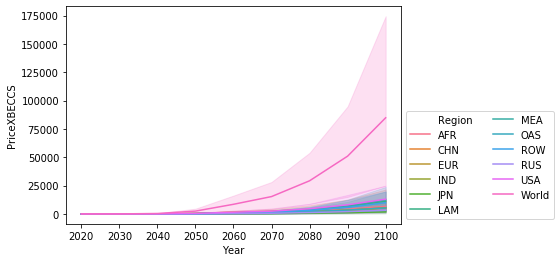

In [138]:
sns.lineplot(x='Year',y='PriceXBECCS',data=main_remind, hue='Region')
plt.legend(loc='lower left', bbox_to_anchor=(1,0),ncol=2)

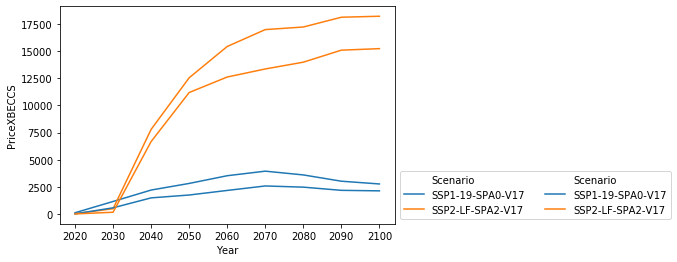

In [139]:
world_data=main_image[main_image.Region==("World")].copy()
sns.lineplot(x='Year',y='PriceXTotalCDR',data=world_data,hue='Scenario')
sns.lineplot(x='Year',y='PriceXBECCS',data=world_data,hue='Scenario')

plt.legend(loc='lower left', bbox_to_anchor=(1,0),ncol=2)

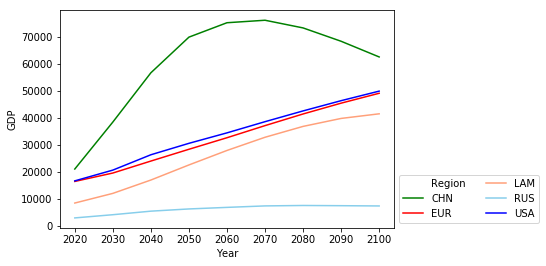

In [16]:
rego = ['LAM', 'USA', 'CHN', 'RUS', 'EUR']
scen='SSP1-19-SPA1-V17'
single_scen=main_remind[(main_remind.Scenario==scen) &
                        (main_remind.Region.isin(rego))].copy()
sns.lineplot(x='Year',y='GDP',data=single_scen, hue="Region", palette=['green','red','lightsalmon','skyblue','blue'], legend="full")
plt.legend(loc='lower left', bbox_to_anchor=(1,0),ncol=2)
plt.savefig(plot_path + 'GDP_per_region_RCP19.png', bbox_inches='tight')

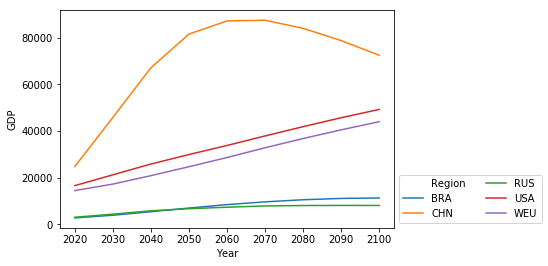

In [24]:
rego = ['BRA', 'USA', 'CHN', 'RUS', 'WEU']
single_scen=main_image[(main_image.Scenario==scen)&
                   (main_image.Region.isin(rego))].copy()
scen='SSP1-19-SPA0-V17'
sns.lineplot(x='Year',y='GDP',data=single_scen,hue='Region')
plt.legend(loc='lower left', bbox_to_anchor=(1,0),ncol=2)

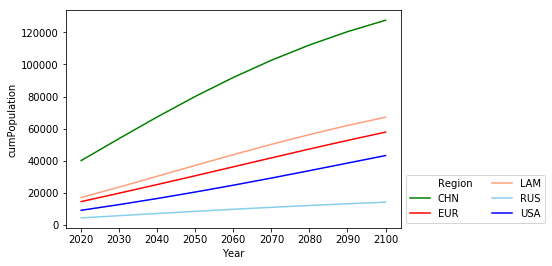

In [26]:
scen='SSP1-19-SPA1-V17'
rego = ['LAM', 'USA', 'CHN', 'RUS', 'EUR']
single_scen=main_remind[(main_remind.Scenario==scen)&(
    main_remind.Region.isin(rego))].copy()
# single_scen=single_scen.set_index('Year')
sns.lineplot(x='Year',y='cumPopulation',data=single_scen,hue='Region', palette=['green','red','lightsalmon','skyblue','blue'])
plt.legend(loc='lower left', bbox_to_anchor=(1,0),ncol=2)
plt.savefig(plot_path + 'cumPopulation_per_region_RCP19.png', bbox_inches='tight')

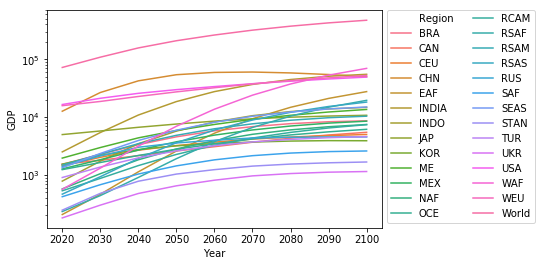

In [109]:
scen='SSP1-19-SPA0-V17'
single_scen=full_df[full_df.Scenario==scen].copy()
# single_scen=single_scen.set_index('Year')
sns.lineplot(x='Year',y='GDP',data=single_scen,hue='Region')
plt.legend(loc='lower left', bbox_to_anchor=(1,0),ncol=2)
plt.yscale('log')

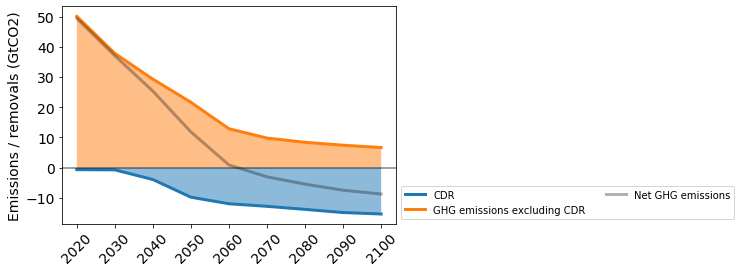

In [188]:
scen = ['SSP1-19-SPA1-V17']
single_reg=main_remind[(main_remind.Scenario.isin(scen)) &
                        (main_remind.Region == 'World')].copy()
single_reg.loc[:,'TOTAL_CDR'] = single_reg.loc[:,'TOTAL_CDR']*-10**-3
single_reg.loc[:,'Total_GHG'] = single_reg.loc[:,'Total_GHG']*10**-3
single_reg.loc[:,'CO2_Emissions'] = single_reg.loc[:,'CO2_Emissions']*10**-3

rfilt = (mdf_remind.Country == 'World')
mdf_remind_world = mdf_remind.loc[(mdf_remind.Year >= '1990') & rfilt].copy()
mdf_remind_world.loc[:,'Value'] = mdf_remind_world.loc[:,'Value']*10**-3

# sns.lineplot(x = 'Year', y = 'Value', data = mdf_remind_world)

sns.lineplot(x='Year',y='TOTAL_CDR',data=single_reg, linewidth = 3, label = 'CDR')
sns.lineplot(x='Year', y='CO2_Emissions',data = single_reg, linewidth = 3, label = 'GHG emissions excluding CDR')
sns.lineplot(x='Year',y='Total_GHG',data=single_reg, linewidth = 3, color = 'black', label = 'Net GHG emissions', alpha = 0.3)
plt.fill_between(np.arange(2020,2110,10), single_reg["TOTAL_CDR"].values, alpha=0.5) 
plt.fill_between(np.arange(2020,2110,10), single_reg["CO2_Emissions"].values, alpha=0.5) 

# plt.line(x = np.arange(2020,2100,10), y = 0)
plt.axhline(0, color='black', linestyle='-', linewidth=1.5, alpha=0.5)
plt.ylabel('Emissions / removals (GtCO2)', fontsize = 14)
plt.yticks(fontsize = 14)
plt.xticks(fontsize = 14, rotation = 45)
plt.xlabel("", fontsize = 14)

plt.legend(loc = 'lower left', bbox_to_anchor=(1,0),ncol=2)
# plt.legend(loc='upper right', fontsize = 14)